In [7]:
pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 MB 1.2 MB/s eta 0:00:00m eta 0:00:010:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 1.2 MB/s eta 0:00:00 MB/s eta 0:00:01:01
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.2
    Uninstalling sympy-1.13.2:
      Successfully uninstalled sympy-1.13.2
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random


In [3]:
# ---- Toy corpus ----
toy_text = "hello\nhelp\nhelium\nhello hello help help"

# ---- Larger text (~50–200 KB) ----
with open("corpus.txt", "r", encoding="utf-8") as f:
    large_text = f.read()

text = toy_text + "\n" + large_text
text

'hello\nhelp\nhelium\nhello hello help help\nCHAPTER I. The Curious Clocktower\n\nLydia had grown quite accustomed to spending her afternoons beneath the old\nelm tree behind her grandmother’s house, but on this particular day she felt\nfar too restless to sit still. The breeze was warm, the clouds were drifting\nlazily overhead, and yet she had the peculiar sense that something unusual\nwas about to happen.\n\nShe toyed with the idea of sketching in her notebook, or perhaps taking a walk\nto the river, but neither seemed interesting enough. Just as she sighed and\nleaned back against the bark, a faint metallic ticking sounded behind her.\nLydia turned—and to her astonishment, a bright brass pocket-watch came hopping\nthrough the grass on its tiny mechanical legs.\n\nAt first she could only stare. There was nothing especially remarkable about a\npocket-watch, of course, but a pocket-watch that moved on its own, clicked its\ngears impatiently, and seemed very much in a hurry—that was qu

In [5]:
chars = sorted(list(set(text)))
stoi = {c:i for i,c in enumerate(chars)}
itos = {i:c for c,i in stoi.items()}

vocab_size = len(chars)
print("Vocab size:", vocab_size)


Vocab size: 44


In [7]:
def encode(s):
    return torch.tensor([stoi[c] for c in s], dtype=torch.long)

def decode(indices):
    return ''.join([itos[i] for i in indices])


In [9]:
class CharDataset(Dataset):
    def __init__(self, data, seq_len=100):
        self.data = encode(data)
        self.seq_len = seq_len
    
    def __len__(self):
        return len(self.data) - self.seq_len - 1
    
    def __getitem__(self, idx):
        chunk = self.data[idx: idx+self.seq_len]
        target = self.data[idx+1: idx+self.seq_len+1]   # next char prediction
        return chunk, target


In [11]:
seq_len = 100
batch_size = 64

dataset = CharDataset(text, seq_len)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)


In [13]:
class CharRNN(nn.Module):
    def __init__(self, vocab_size, emb_size=128, hidden_size=256):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, emb_size)
        self.rnn = nn.GRU(emb_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, x, h=None):
        x = self.embed(x)
        out, h = self.rnn(x, h)
        logits = self.fc(out)
        return logits, h


In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CharRNN(vocab_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [17]:
train_losses = []
val_losses = []

epochs = 10

for ep in range(epochs):
    model.train()
    total_loss = 0

    for X, Y in train_loader:
        X, Y = X.to(device), Y.to(device)
        
        logits, _ = model(X)
        loss = criterion(logits.reshape(-1, vocab_size), Y.reshape(-1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X, Y in val_loader:
            X, Y = X.to(device), Y.to(device)
            logits, _ = model(X)
            loss = criterion(logits.reshape(-1, vocab_size), Y.reshape(-1))
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))
    print(f"Epoch {ep+1}/{epochs}  Train={train_losses[-1]:.4f}  Val={val_losses[-1]:.4f}")


Epoch 1/10  Train=3.0010  Val=2.5472
Epoch 2/10  Train=2.3156  Val=2.1191
Epoch 3/10  Train=1.9276  Val=1.7338
Epoch 4/10  Train=1.5358  Val=1.3280
Epoch 5/10  Train=1.1294  Val=0.9254
Epoch 6/10  Train=0.7519  Val=0.5851
Epoch 7/10  Train=0.4606  Val=0.3543
Epoch 8/10  Train=0.2821  Val=0.2300
Epoch 9/10  Train=0.1908  Val=0.1686
Epoch 10/10  Train=0.1446  Val=0.1368


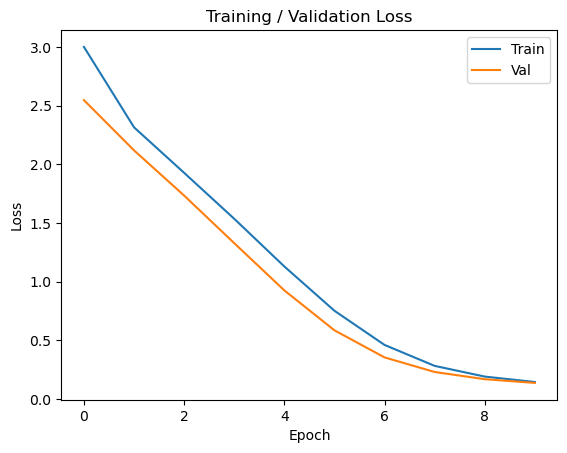

In [18]:
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training / Validation Loss")
plt.show()


In [19]:
def sample(model, start_text="h", length=300, temperature=1.0):
    model.eval()
    idx = encode(start_text).unsqueeze(0).to(device)
    h = None

    for _ in range(length):
        logits, h = model(idx[:, -1].unsqueeze(1), h)
        logits = logits[:, -1, :] / temperature
        prob = torch.softmax(logits, dim=-1)
        next_id = torch.multinomial(prob, 1)
        idx = torch.cat([idx, next_id], dim=1)

    return decode(idx[0].tolist())

print("τ=0.7:\n", sample(model, "h", 300, 0.7))
print("\nτ=1.0:\n", sample(model, "h", 300, 1.0))
print("\nτ=1.2:\n", sample(model, "h", 300, 1.2))


τ=0.7:
 he toyed with the idea of sketching in her notebook, or perhaps taking a walk
to the river, but neither seemed interesting enough. Just as she sighed and
leaned back against the bark, a faint metallic ticking sounded behing sened behind her grandmother’s house, but on this particular day she felt
far

τ=1.0:
 ht particular day she fore, but a pocktower wother it. She alouds were drifting
lazily overhead, and yet she had the peculiar seen, and yet sneath the  fieltwal
lyary, and seemed very much in a hurry—that wagh a ardovery a onled yet seemed betarnibetallic its tiny mechanical legs.

At fier after it. 

τ=1.2:
 her tomemtlestle, Lydia slipped inside afder door.

Jut aA the grasteben.

She toyed with the edea hud hec on its ownt, spending her afternoons benlived to notebook, or perhaps tainst the bay sensighed very much in ae hurrint. The but enteresting enough. The aldrwer otresqime tofed with the eemoveble


### Reflection:

Increasing the sequence length allows the model to capture longer-range dependencies, improving coherence but also increasing training time and difficulty. A larger hidden size usually improves the model’s capacity to learn richer patterns, but it may overfit and requires more memory. During sampling, temperature strongly affects creativity: low τ (≈0.7) produces more repetitive and conservative text, τ = 1.0 gives balanced diversity, and high τ (1.2+) produces creative but often incoherent sequences. Teacher forcing helps the model converge faster by providing the correct previous character, but it can make sampling more brittle when the model must rely on its own predictions. Overall, the RNN learns meaningful character-level structure, but its generation quality is sensitive to these hyperparameters.